In this study, we will analyze the historical series of S&P500 prices by downloading data from Yahoo Finance (yfinance).The analysis of this time series will be structured into four main points:

* **Stationarity Check**:
We will begin by examining the stationarity of the time series. This is a crucial step, since many statistical forecasting methods require the time series to be stationary. We will apply tests such as the Augmented Dickey-Fuller (ADF) test to determine if differencing or other transformations are necessary to achieve stationarity.

* **Model Identification**:
Once stationarity is established, we will proceed with model identification. This involves determining the appropriate model to use for prediction, with a focus on the ARIMA (AutoRegressive Integrated Moving Average) model in our case. We will select the optimal values for the parameters p (the number of lag observations included in the model), d (the number of times that the raw observations are differenced), and q (the size of the moving average window). The identification process will involve analyzing the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots, along with using information criteria such as AIC (Akaike Information Criterion).

* **Model Prediction and Reflection**:
After identifying the appropriate model, we will perform predictions based on the model. We will discuss the accuracy and reliability of the predictions, taking into account metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

* **Comparison with other model Forecasting Models**:
Finally, we will propose a comparison between the model currently identifyed and a XGBoost and Persistence models. This comparison aims to evaluate the performance of traditional statistical methods like ARIMA versus modern machine learning approaches, and to assess the feasibility of one-day predictions for complex data like Stock Market prices.

## Load Libraries

In [1]:
#!pip install yfinance
#!pip install pmdarima


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from numpy.polynomial.polynomial import Polynomial
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.fft import fft, fftfreq
from xgboost import XGBRegressor

## Import Data from YahooFinance

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000


Text(0.5, 1.0, 'S&P500 Time Series Data')

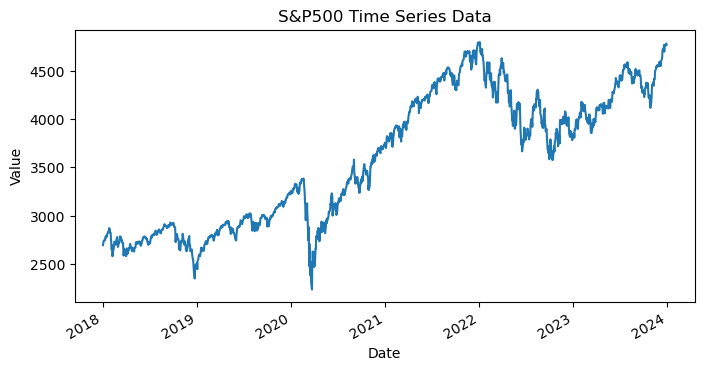

In [3]:
# Load the Time Series
ticker = '^GSPC'

# Download stock price data
df = yf.download(ticker, start='2018-01-01', end='2023-12-31')

# Display the first few rows
display(df.head())

# Plot the time series
df['Adj Close'].plot(figsize=(8, 4))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('S&P500 Time Series Data')

## Brief introduction about what a stationary process is
    


A stochastic process is said to be stationary if its statistical properties  don't change over time. Therefore, time series containing trend or seasonal components are not stationary, as the trend and seasonality affect the value of the time series at different times.  There are three main properties of a stationary process:

* The **mean value** is constant over time. This means that regardless of when you look at the process, the average value will be the same. In mathematical terms, this is written as: $${E}[x(t)] = m_x(t) = m_x(t + \tau), \quad \forall \tau \in {R}$$
* The **variance**, denoted by $\mathrm{Var}[t]$, is also constant over time. The variance tells you how spread out the data is from the mean. So, a constant variance means that the data is neither becoming more spread out nor more concentrated over time.
* The **covariance**, denoted by $\gamma(\tau)$, only depends on the time difference $\tau$ between two observations $t_1$ and $t_2$. Covariance measures how much two variables change together. So, this property says that the relationship between the values of the process at two different times only depends on how far apart in time those two times are. Mathematically, this is written as:$${E}[(x(t_1) - m_x(t_1))(x(t_2) - m_x(t_2))] = C_x(t_1, t_2) = C_x(t_1 - t_2, 0)$$

First of all we have to assess the stationarity of our process.

## Check if there is some Polynomial trend in our Time Series

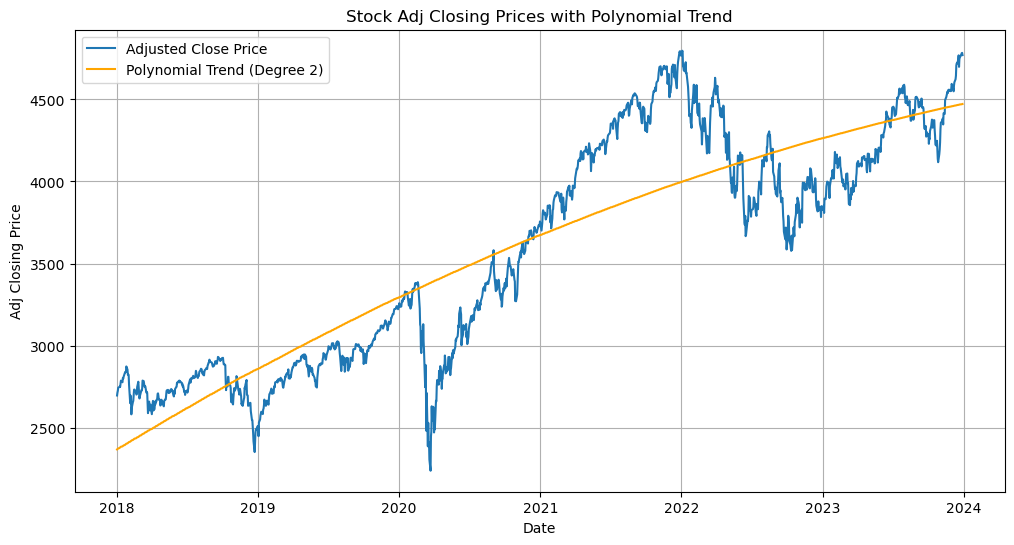

In [4]:
x = np.arange(len(df['Adj Close']))
y = df['Adj Close'].values

p = Polynomial.fit(x, y, deg=2)  # Fit a 2nd degree polynomial
plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close'], label='Adjusted Close Price')
plt.plot(df.index, p(x), label='Polynomial Trend (Degree 2)', color='orange')
plt.title('Stock Adj Closing Prices with Polynomial Trend')
plt.xlabel('Date')
plt.ylabel('Adj Closing Price')
plt.legend()
plt.grid(True)
plt.show()

## Check for Stationarity

We will use Augmented Dickey Fuller test in order to evaluate the stationarity of our series.

The **Null Hp** is the absence of stationarity, so if the p-value will be less than our significance level (eg:0.05) we have to reject the null Hp assessing that our series is stationary.

In [5]:
result = adfuller(df['Adj Close'].dropna())

print('p-value:', result[1])

if result[1] > 0.05:
    print("The series is not stationary")
else:
    print("The series is stationary at 5% level of confidence")

p-value: 0.8165267079829671
The series is not stationary



Since we observed a polynomial trend and the Augmented Dickey-Fuller test indicated that our series is nonstationary  with a $p-value$ of $0.82$, we need to transform it to achieve stationarity before proceeding with our analysis.

We will reached this goal through **Differencing**, which is a technique used to make our process stationary. However, even if we just difference once, we might not get a stationary series so we might need to do that multiple times.

The minimum number of differencing operations nedeed to make the series stationary must be imputeted into our arima model.

Why differencing?




In [6]:
diff1 = adfuller(np.diff(df['Adj Close'].dropna()))

print('p-value:', diff1[1])

if  diff1[1] > 0.05:
    print("The series is not stationary")
else:
    print("The series is stationary at 5% level of confidence")

p-value: 3.670698284068165e-22
The series is stationary at 5% level of confidence


The Augmented Dickey-Fuller test now indicates stationarity with a $p$-value of $3.68 \times 10^{-22}$. Therefore, we must reject the null hypothesis of nonstationarity and conclude that there is strong evidence of stationarity.

We will use as parameter d in our model d=1

## Model Specification

It refers to detect the correct parameters for our model.
Usually, it is not possible to determine simply by looking at the plot of a time series which values of p and q are appropriate for the data. However, sometimes it is possible to use the ACF plot, and its closely related PACF plot, to determine the appropriate values of p and q.



P is the order of the Auto Regressive (AR) term. **It refers to the number of lags to be used as predictors.** We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
The partial autocorrelation represents the **correlation between the series and its lags** (lagged version of itself).

Q is the order of the Moving Average (MA) term. **It refers to the number of lagged forecast errors used as predictors**. 

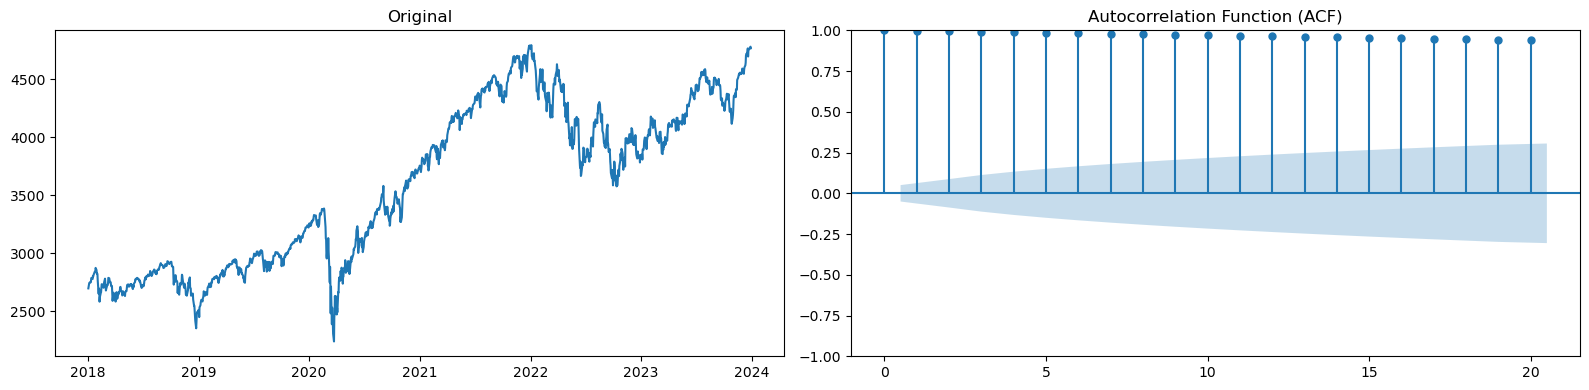

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4)) #initialize the two graphics


ax1.plot(df['Adj Close'])
ax1.set_title('Original')
# ACF plot
plot_acf(df['Adj Close'], ax=ax2, lags=20)
ax2.set_title('Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()

The ACF plot of the original series **decreases slowly**. This happens when we
do not difference our series. In fact, this effect is due to the incorporation of the trend that connects the different time lags.

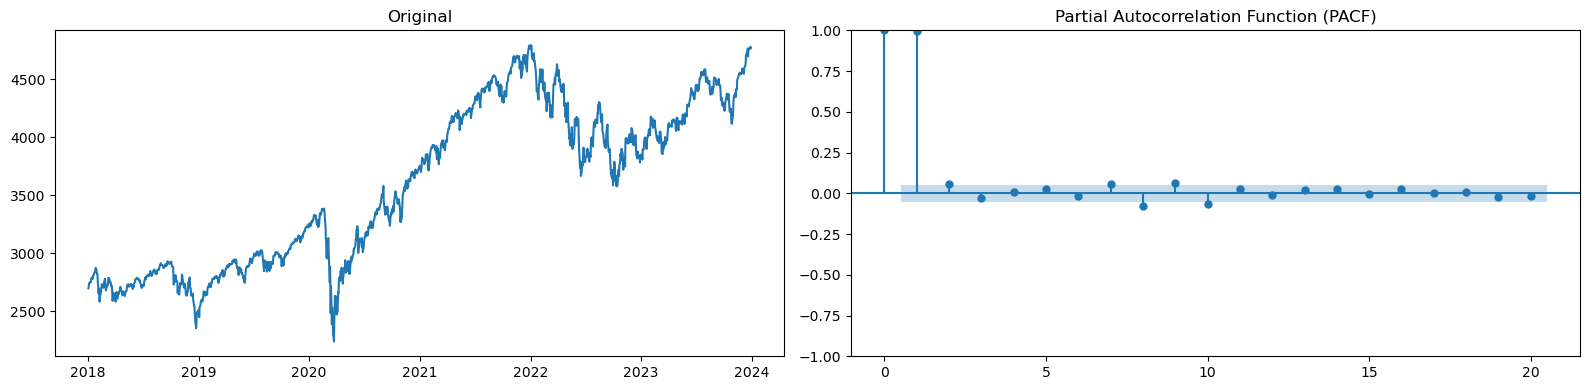

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4)) #initialize the two graphics


ax1.plot(df['Adj Close'])
ax1.set_title('Original')


# PACF plot
plot_pacf(df['Adj Close'], ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

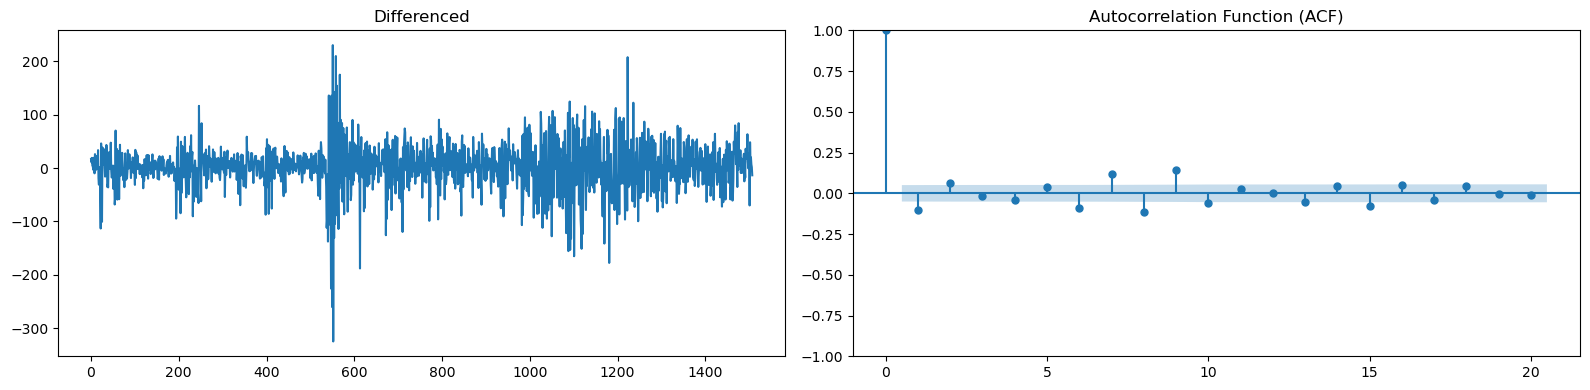

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4)) #initialize the two graphics


ax1.plot(np.diff(df['Adj Close'].dropna()))
ax1.set_title('Differenced')
# ACF plot
plot_acf(np.diff(df['Adj Close'].dropna()), ax=ax2, lags=20)
ax2.set_title('Autocorrelation Function (ACF)')

plt.tight_layout()
plt.show()

The ACF plot of the differenced series exhibits **pure white noise**, as there are no significant peaks, indicating no predictability because the series has no
memory of itself. Infact AFC only has a significant correlation at lag zero.

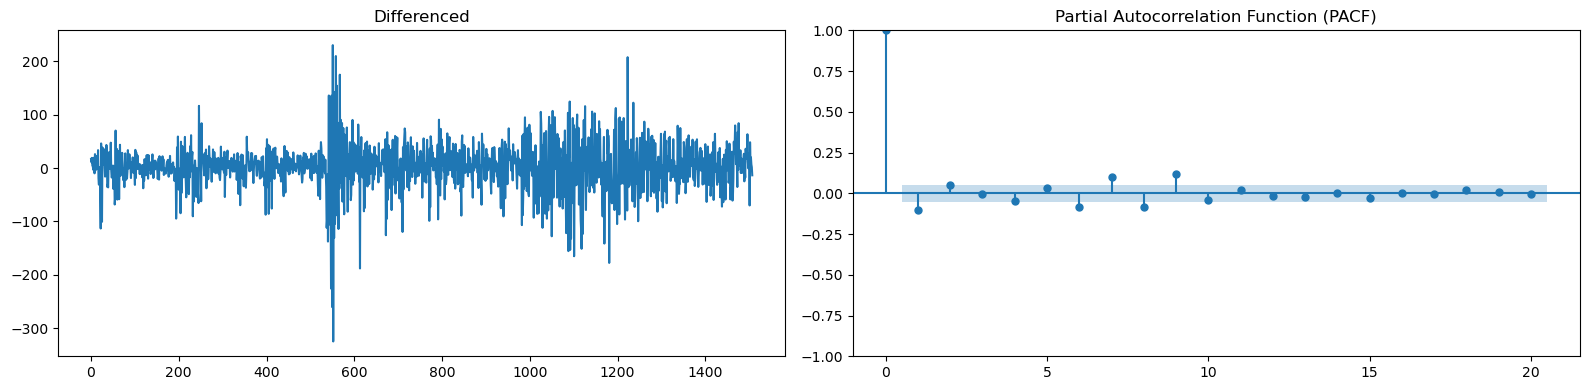

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4)) #initialize the two graphics


ax1.plot(np.diff(df['Adj Close'].dropna()))
ax1.set_title('Differenced')


# PACF plot
plot_pacf(np.diff(df['Adj Close'].dropna()), ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Ceck for Seasonality
However, there is still another analysis to be done: checking for the presence of a seasonal component. This is typically not present in specific series such as stock prices. In fact, had there been any seasonality left, it would have been seen in the AC plot. But we basically get pure noise. Nevertheless, we can investigate this further using spectral analysis, which allows us to detect any seasonal components.


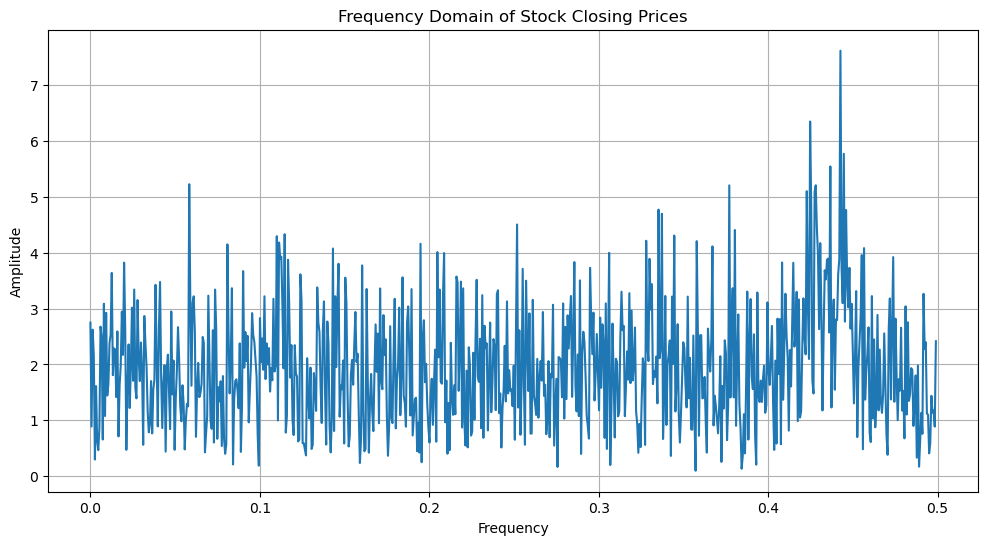

In [11]:
# Number of sample points
N = len(df['Adj Close'].values)

# Sample spacing (assuming daily data, so delta_t is 1)
delta_t = 1

# Perform the FFT
yf = fft(np.diff(df['Adj Close'].dropna()))
xf = fftfreq(N, delta_t)[:N//2]

# Plot the FFT results
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('Frequency Domain of Stock Closing Prices')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

The FFT is an algorithm that computes the Discrete Fourier Transform (DFT) of a sequence. It converts a time-domain signal into its frequency components, showing how much of each frequency exists in the original signal. Here we can observe the same *energy* for each freqeuncy

## Automatic detection of the best parameter configuration
Since it seems to be difficult to manually identify the correct values for p and q, we can use another approach based on the AIC criteria.
**AIC stands for Akaike Information Criteria**, and it’s a statistical measure that we can use to compare different models for their relative quality. It measures the quality of the model in terms of its goodness-of-fit to the data, its simplicity, and how much it relies on the tuning parameters.
$$ AIC = 2k - 2l $$
where $l$ is a log-likelihood, and $k$ is a number of parameters. 

The **auto arima** function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model.

But what's **Arima** model?

ARIMA is an acronym for AutoRegressive Integrated Moving Average (in this context, “integration” is the reverse of differencing).

The full model can be written as:
$$ y^{'}_{t} = \mu + \phi_1 y^{'}_{t-1} + \phi_2 y^{'}_{t-2} + \ldots + \phi_p y^{'}_{t-p} + \epsilon_t - \theta_1 \epsilon_{t-1} - \theta_2 \epsilon_{t-2} - \ldots - \theta_q \epsilon_{t-q} $$
where $y^{'}_{t}$ is the differenced series (it may have been differenced more than once). The “predictors” on the right hand side include both lagged values of $y^{'}_{t}$ and lagged errors $\epsilon$.

In [12]:
size = int(len(df['Adj Close'])*0.95)
train_df = (df['Adj Close'])[:size]
test_df = (df['Adj Close'])[size:]


print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")

model = auto_arima(train_df, test = 'adf', 
                  start_p = 0, start_q = 0,     
                  max_p = 3, max_q = 3,
                  d = None, seasonal = False,  m = 1,
                  trace = True, error_action = 'ignore',  
                  suppress_warnings = True,
                  stepwise = True, information_criterion = 'aic')

print(model.summary())

Train Size: 1433, Test Size: 76
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14894.354, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14879.344, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14880.919, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14893.488, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14878.139, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=14880.005, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14880.097, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14878.882, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14880.886, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=14877.422, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14878.755, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=14879.312, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=14879.386, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14878.238, T

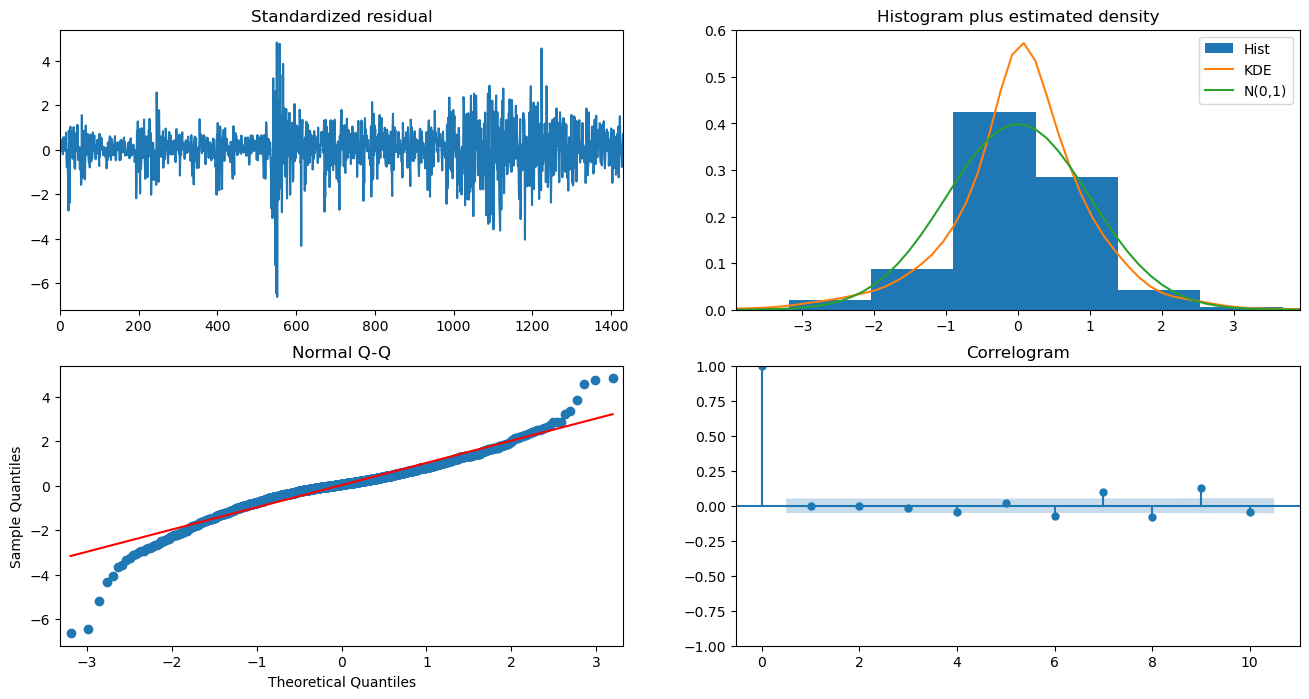

In [13]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

So how to interpret the plot diagnostics?

**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right**: The density plot suggest normal distribution with mean zero.

**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

## Model Predict

In [14]:
steps = len(test_df)
forecast, confidence_interval = model.predict(X=test_df, n_periods = len(test_df), return_conf_int = True)

forecasts = pd.Series(forecast.values, index = test_df[:steps].index)
lower = pd.Series(confidence_interval[:, 0], index = test_df[:steps].index)
upper = pd.Series(confidence_interval[:, 1], index = test_df[:steps].index)


/opt/homebrew/Caskroom/miniconda/base/envs/cvs-classifier/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniconda/base/envs/cvs-classifier/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Model Evaluation

In [15]:
mse = mean_squared_error(test_df, forecasts)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_df, forecasts)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_df, forecasts))
print('RMSE: '+str(rmse))

MSE: 32389.146062715965
MAE: 155.52556596925515
RMSE: 179.96984764875467


### 1 day prediction

In [16]:
rmse = math.sqrt(mean_squared_error(test_df.values[0:1], forecast.values[0:1]))
print('True value: '+str(test_df.values[0]))
print('Predicted value: '+str(forecast.values[0]))
print('RMSE: '+str(rmse))

True value: 4467.43994140625
Predicted value: 4465.966052342302
RMSE: 1.4738890639482634


### 10 Days prediction

In [17]:
rmse = math.sqrt(mean_squared_error(test_df.values[10:11], forecast.values[10:11]))
print('True value: '+str(test_df.values[10]))
print('Predicted value: '+str(forecast.values[10]))
print('RMSE: '+str(rmse))

True value: 4274.509765625
Predicted value: 4464.587854201639
RMSE: 190.07808857663895


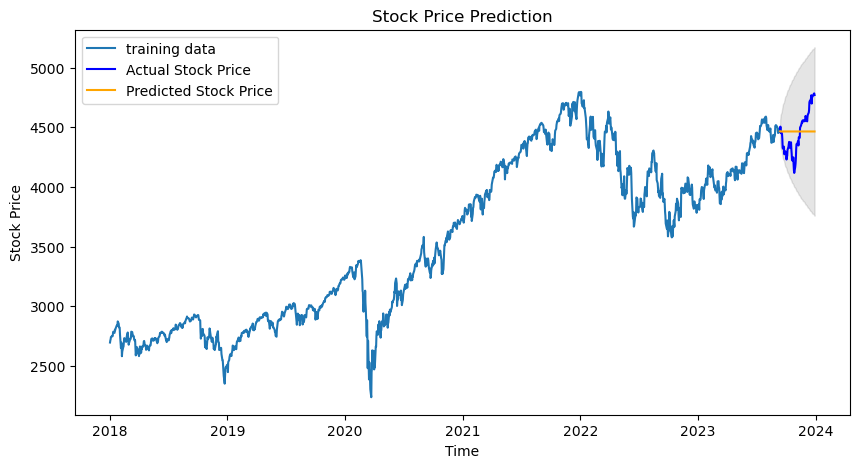

In [18]:
fc_series = pd.Series(forecast.values, index=test_df.index)
lower_series = pd.Series(lower, index=test_df.index)
upper_series = pd.Series(upper, index=test_df.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_df, label='training data')
plt.plot(test_df, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=10)
plt.show()

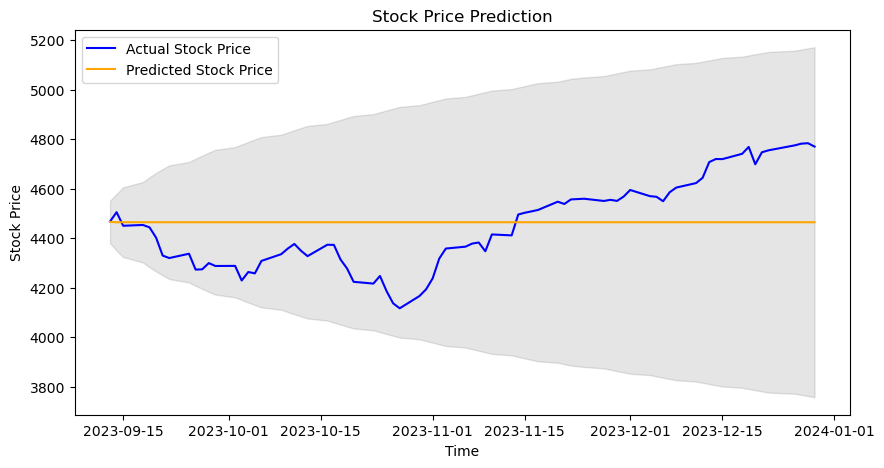

In [19]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(test_df, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=10)
plt.show()

## Daily ARIMA forcasting

In [20]:
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat


# Walk-forward validation
history = [x for x in train_df]
predictions = []
for t in range(len(test_df)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test_df[t]
    history.append(obs)

fc_series_daily = pd.Series(predictions, index=test_df.index)


/var/folders/hy/jr30g0797s1fmbhl3_td2mvm0000gn/T/ipykernel_52980/4020928795.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test_df[t]


## Metrics

In [21]:
mse_arima = mean_squared_error(test_df, predictions)
print('MSE: '+str(mse))
mae_arima = mean_absolute_error(test_df, predictions)
print('MAE: '+str(mae))
rmse_arima = math.sqrt(mean_squared_error(test_df, predictions))
print('RMSE: '+str(rmse))

MSE: 32389.146062715965
MAE: 155.52556596925515
RMSE: 190.07808857663895


## Visualization

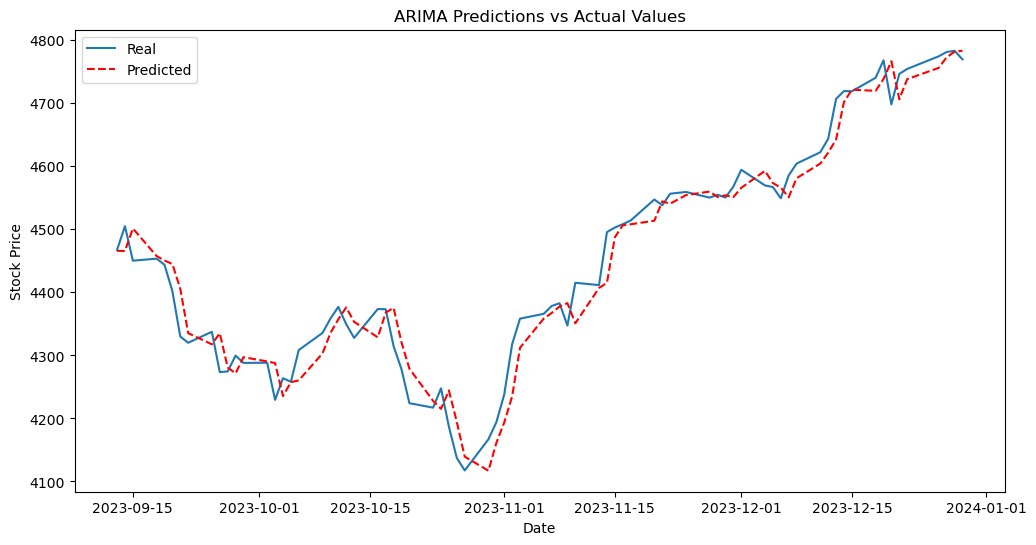

In [22]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_df.index, test_df, label='Real')
plt.plot(test_df.index, fc_series_daily, color='red', label='Predicted',linestyle='--')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Comparison with xgboost Model

In [23]:
df['target'] = df['Adj Close'].shift(-1)
df.dropna(inplace=True)
new_df = df[['Adj Close', 'target']]
new_df.head()

# Split the data into train and test sets
size = int(len(new_df) * 0.95)
train_df = new_df[:size]
test_df = new_df[size:]

print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")

Train Size: 1432, Test Size: 76


## Daily forcasting

In [24]:
# Function to fit and predict using XGBoost
def Xgb_predict(train, test):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    model.fit(train[['Adj Close']], train['target'])
    output = model.predict(test[['Adj Close']])
    return output

# Preparing the history and predictions list
history = train_df.copy()
xgb_preds = []

# Predicting the target for the test set
for i in range(len(test_df)):
    test_X = test_df.iloc[i:i+1]  # Taking one row at a time
    yhat = Xgb_predict(train=history, test=test_X)
    xgb_preds.append(yhat[0])
    history = pd.concat([history, test_X])

## Metrics

In [25]:
mse_xgb = mean_squared_error(test_df['target'], xgb_preds)
print('MSE: '+str(mse))
mae_xgb = mean_absolute_error(test_df['target'], xgb_preds)
print('MAE: '+str(mae))
rmse_xgb = math.sqrt(mean_squared_error(test_df['target'],xgb_preds))
print('RMSE: '+str(rmse))

MSE: 32389.146062715965
MAE: 155.52556596925515
RMSE: 190.07808857663895


##  Visualization

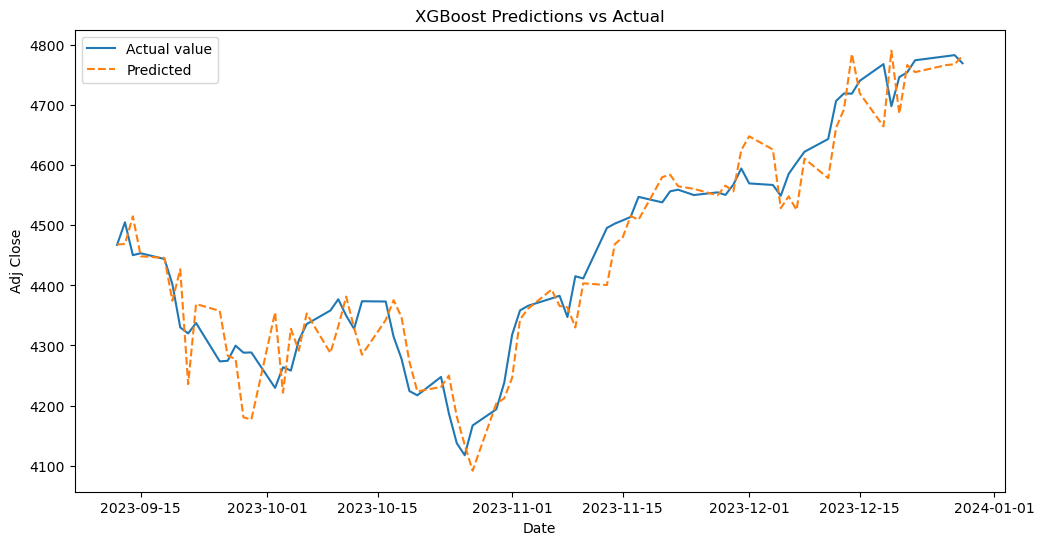

In [26]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['target'], label='Actual value')
plt.plot(test_df.index, xgb_preds, label='Predicted', linestyle='--')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

## Persistance Model


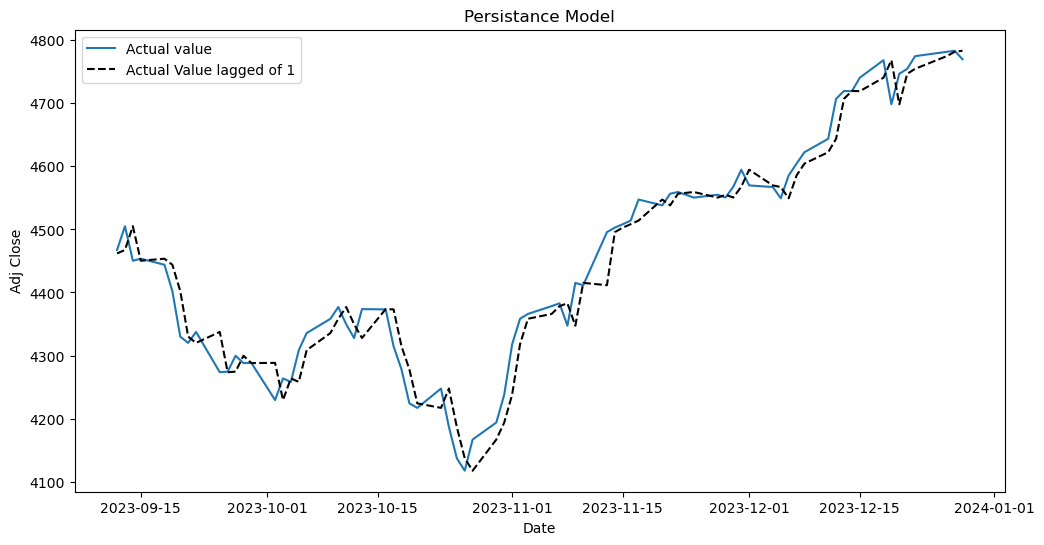

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['target'], label='Actual value')
plt.plot(test_df.index, test_df['Adj Close'], color='black', label='Actual Value lagged of 1', linestyle='--')
plt.title('Persistance Model')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

## Metrics

In [28]:
mse_persistance = mean_squared_error(test_df['target'], test_df['Adj Close'])
print('MSE: '+str(mse))
mae_persistance = mean_absolute_error(test_df['target'], test_df['Adj Close'])
print('MAE: '+str(mae))
rmse_persistance = math.sqrt(mean_squared_error(test_df['target'],test_df['Adj Close']))
print('RMSE: '+str(rmse))

MSE: 32389.146062715965
MAE: 155.52556596925515
RMSE: 190.07808857663895


## Conlusion
Forecasting the stock market is a complex task. As we have seen, even with the creation of two prediction models, we were unable to outperform the persistent model, which assumes that tomorrow will be like today and does not require any adjustment of parameters. Therefore, this leads us to conclude that we need much more information and data to beat the persistence model. Otherwise, creating models would be futile since the persistent model prevails over others.

In [29]:
df = pd.DataFrame({'Metrics':['mse','rmse','mae'],
                  'ARIMA':[mse_arima,rmse_arima,mae_arima],
                  'XGBoost':[mse_xgb,rmse_xgb,mae_xgb],
                  'PersistanceModel':[mse_persistance,rmse_persistance,mae_persistance]
                  })

display(df)

,Metrics,ARIMA,XGBoost,PersistanceModel
0,mse,1208.244302,2670.558618,1184.049331
1,rmse,34.759809,51.677448,34.410018
2,mae,27.265789,40.532214,26.554360
